## Import libraries

In [11]:
## Import libraries for machine learning and data processing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
## For random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
## Add libraries for SMOTE


## Read dataset

In [13]:
## import dataset
raw_feature_df_scaled = pd.read_csv('/Users/adityaponnada/Downloads/time_study_data/processed_features_v1.csv')
## Display the first few rows of the dataset
raw_feature_df_scaled.head()

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,time_of_day_Night,location_category_Home,location_category_Other,location_category_School,location_category_Transit,location_category_Work,wake_day_part_0.0,wake_day_part_1.0,wake_day_part_2.0,wake_day_part_3.0
0,certifiedembargobartender@timestudy_com,1,1,0.0,0.0,1,0.995567,0.0,0.000000,0.891772,...,0,0,0,0,1,0,1,0,0,0
1,certifiedembargobartender@timestudy_com,1,1,NaN,NaN,1,0.995567,0.0,0.000000,0.883542,...,0,0,0,0,1,0,1,0,0,0
2,certifiedembargobartender@timestudy_com,0,1,0.0,1.0,0,NaN,1.0,0.301667,0.852631,...,0,0,1,0,0,0,1,0,0,0
3,certifiedembargobartender@timestudy_com,1,1,0.0,1.0,1,0.995567,0.0,0.000000,0.844384,...,0,0,0,0,1,0,1,0,0,0
4,certifiedembargobartender@timestudy_com,1,1,NaN,NaN,0,0.995705,1.0,0.150000,0.831944,...,0,0,0,0,1,0,1,0,0,0


In [14]:
## Inspect the number of unique participant_ids
num_participants = raw_feature_df_scaled['participant_id'].nunique()
print(f"Number of unique participants: {num_participants}")

## Check the shape of the dataset
num_rows, num_cols = raw_feature_df_scaled.shape
print(f"Dataset shape: {num_rows} rows, {num_cols} columns")

Number of unique participants: 10
Dataset shape: 108075 rows, 31 columns


## Split training and test data
First 80% data from each user as part of training. Then the remaining 20% for testing from all users.

In [15]:
def split_train_test_by_participant(df, id_col='participant_id', train_frac=0.8):
    """
    Splits the DataFrame into training and testing sets for each participant.
    The first train_frac (default 80%) of each participant's data goes to train, the rest to test.
    Returns: train_df, test_df
    """
    train_list = []
    test_list = []
    for pid, group in df.groupby(id_col):
        n = len(group)
        split_idx = int(np.floor(train_frac * n))
        group_sorted = group.sort_index()  # keep original order
        train_list.append(group_sorted.iloc[:split_idx])
        test_list.append(group_sorted.iloc[split_idx:])
    train_df = pd.concat(train_list).reset_index(drop=True)
    test_df = pd.concat(test_list).reset_index(drop=True)
    return train_df, test_df

# Apply the function to split the dataset
train_df, test_df = split_train_test_by_participant(raw_feature_df_scaled)
print(f"Train set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

Train set shape: (86456, 31)
Test set shape: (21619, 31)


### Verify training distribution

In [16]:
def participant_split_summary(train_df, test_df, id_col='participant_id'):
    """
    Returns a DataFrame with columns: participant_id, n_train, n_test, pct_train, pct_test
    """
    train_counts = train_df.groupby(id_col).size().rename('n_train')
    test_counts = test_df.groupby(id_col).size().rename('n_test')
    summary = pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)
    summary['total'] = summary['n_train'] + summary['n_test']
    summary['pct_train'] = (summary['n_train'] / summary['total'] * 100).round(2)
    summary['pct_test'] = (summary['n_test'] / summary['total'] * 100).round(2)
    summary = summary.reset_index()[[id_col, 'n_train', 'n_test', 'pct_train', 'pct_test']]
    return summary

# Example usage:
split_summary = participant_split_summary(train_df, test_df)
split_summary

,participant_id,n_train,n_test,pct_train,pct_test
0,certifiedembargobartender@timestudy_com,9244,2311,80.00,20.00
1,chewingslouchingfailing@timestudy_com,10626,2657,80.00,20.00
2,enjoyergoofinessgrudge@timestudy_com,8365,2092,79.99,20.01
3,erasuresafeguardravishing@timestudy_com,3565,892,79.99,20.01
4,neutergoldfishsworn@timestudy_com,6979,1745,80.00,20.00
5,persevereriseswoop@timestudy_com,10394,2599,80.00,20.00
6,pretendedconstrainfraying@timestudy_com,12352,3088,80.00,20.00
7,remoldexcludingaffair@timestudy_com,5140,1286,79.99,20.01
8,slapstickporcupineslacks@timestudy_com,9149,2288,79.99,20.01
9,subtitlegrievousbazooka@timestudy_com,10642,2661,80.00,20.00


## Apply SMOTE to training data

In [17]:
# Apply SMOTE to the training data to address class imbalance (with median imputation for missing values)
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
feature_cols = [col for col in train_df.columns if col not in ['outcome', 'participant_id']]
X_train = train_df[feature_cols]
y_train = train_df['outcome']
# Impute missing values in X_train using median strategy
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_imputed, y_train)
# Convert back to DataFrame with feature names to avoid warning
X_train_resampled = pd.DataFrame(X_train_resampled, columns=feature_cols)
print('Original training set class distribution:')
print(y_train.value_counts())
print('Resampled training set class distribution:')
print(pd.Series(y_train_resampled).value_counts())

Original training set class distribution:
outcome
1    74766
0    11690
Name: count, dtype: int64
Resampled training set class distribution:
outcome
1    74766
0    74766
Name: count, dtype: int64


## Train a RandomForest classifier
To predict the next 20% of the dfata per user

In [18]:
def train_random_forest_classifier(X, y, random_state=42):
    """
    Trains a RandomForestClassifier on the provided features and labels.
    Uses class_weight='balanced' to handle class imbalance.
    Returns the trained model.
    """
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(
        class_weight='balanced',
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=10,
        max_features='sqrt',
        n_estimators=100,
        random_state=random_state
    )
    clf.fit(X, y)
    return clf

# Example usage:
rf_model = train_random_forest_classifier(X_train_resampled, y_train_resampled)

## Test on the test data

In [21]:
def evaluate_classifier_on_test(model, test_df, outcome_col='outcome', id_col='participant_id'):
    """
    Evaluates the classifier on test_df and prints accuracy, precision, recall, F1, and AUC.
    """
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    feature_cols = [col for col in test_df.columns if col not in [outcome_col, id_col]]
    X_test = test_df[feature_cols]
    y_test = test_df[outcome_col]
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'AUC: {auc:.4f}' if auc is not None else 'AUC: Not available')
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'auc': auc}

# Example usage:
results = evaluate_classifier_on_test(rf_model, test_df)

Accuracy: 0.7793
Precision: 0.9498
Recall: 0.7916
F1 Score: 0.8635
AUC: 0.8322


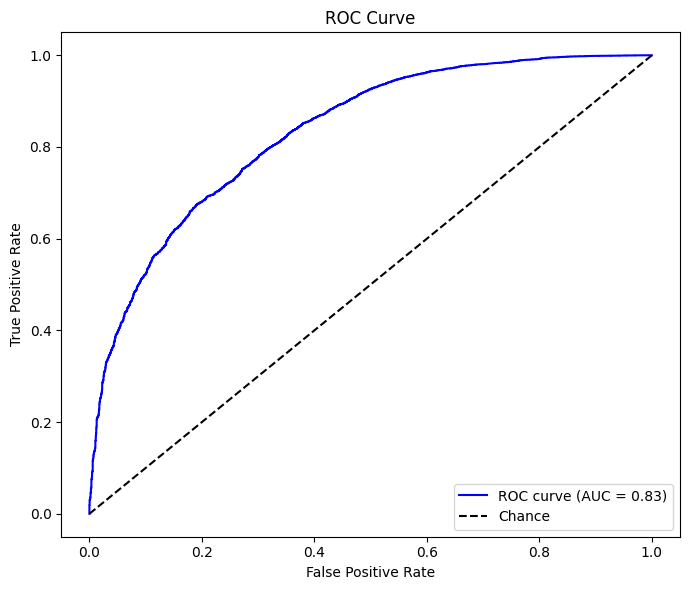

AUC: 0.8322


In [22]:
def plot_roc_curve(model, test_df, outcome_col='outcome', id_col='participant_id'):
    """
    Plots the ROC curve for the model on test_df and prints the AUC.
    """
    from sklearn.metrics import roc_curve, roc_auc_score
    import matplotlib.pyplot as plt
    feature_cols = [col for col in test_df.columns if col not in [outcome_col, id_col]]
    X_test = test_df[feature_cols]
    y_test = test_df[outcome_col]
    if hasattr(model, 'predict_proba'):
        y_scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_scores = model.decision_function(X_test)
    else:
        raise ValueError('Model does not support probability or decision function output.')
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    auc = roc_auc_score(y_test, y_scores)
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})', color='blue')
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f'AUC: {auc:.4f}')

# Example usage:
plot_roc_curve(rf_model, test_df)

In [ ]:
def plot_precision_recall_curve(model, test_df, outcome_col='outcome', id_col='participant_id'):
    """
    Plots the Precision-Recall curve for the model on test_df and prints the average precision score.
    """
    from sklearn.metrics import precision_recall_curve, average_precision_score
    import matplotlib.pyplot as plt
    feature_cols = [col for col in test_df.columns if col not in [outcome_col, id_col]]
    X_test = test_df[feature_cols]
    y_test = test_df[outcome_col]
    if hasattr(model, 'predict_proba'):
        y_scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_scores = model.decision_function(X_test)
    else:
        raise ValueError('Model does not support probability or decision function output.')
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    avg_precision = average_precision_score(y_test, y_scores)
    plt.figure(figsize=(7, 6))
    plt.plot(recall, precision, color='b', label=f'AP={avg_precision:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    print(f'Average Precision Score: {avg_precision:.4f}')

# Example usage:
plot_precision_recall_curve(rf_model, test_df)